In [28]:
import pandas as pd
import numpy as np
from ast import literal_eval
import joblib as jb
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor


# Data Reading and Parsing
- Let's read the data as a string, transform it to a dictionary, and then use Pandas tools to parse the json
- Let's create an identifier for each purchase "nnota"

In [4]:
with open('sample.txt', 'r') as fl:
    fl = fl.read()
data = pd.io.json.json_normalize(literal_eval(fl))
data['nnota'] = np.arange(data.shape[0])

Here we want to parse the products of each purchase in its own dataframe, so that we can use this data. We do it in parallel to go faster

In [5]:
def parseProds(i):
    row = data.iloc[i]
    df = pd.io.json.json_normalize(row['dets'])
    df['nnota'] = row['nnota']
    return df

res = jb.Parallel(n_jobs=-1, verbose=5)(jb.delayed(parseProds)(i) for i in range(data.shape[0]))
prod_df = pd.concat(res)

[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1635 out of 1635 | elapsed:    2.1s finished


Drop original product list column and merge with the purchase data into the "full" dataframe

In [6]:
full = prod_df.merge(data.drop('dets', axis=1), how='left', on='nnota')

Drop any columns that have only one value

In [7]:
drops = []
for col in full.columns:
    if full[col].nunique() == 1:
        drops.append(col)
full.drop(drops, axis=1, inplace=True)

Create a date column with an easier name, and extract the week

In [8]:
full['date'] = pd.to_datetime(full['ide.dhEmi.$date'])
full['week'] = full['date'].dt.week

# Forecasting model
- To "forecast sales next week" we need to take some decisions according to the value this model can bring to the business. Based on my experience, predicting the amount of each item that will be sold next week is very useful for inventory managers. So I assume this is the most valuable forecast for the business in this case (in real life we would ask questions to the client to clarify)
- To make sure our model can predict new data, let's separate the first 2 weeks for "training" and the last week for "validation".
- The metric used to evaluate the model is RMSLE (Root Mean Squared Logarithmic Error), which is a good approximation of the percentage error.

Let's transform the data into a "week, product, sales quantity" format, so that we can predict the amount of each item that will be sold next week

In [9]:
new_df = full.groupby(['week', 'prod.xProd'])['prod.qCom'].sum().reset_index()
new_df.head()

,week,prod.xProd,prod.qCom
0,1,AGUA,212.000
1,1,BUFFET,292.276
2,1,BULE CHA,5.000
3,1,CAFE EXPRESSO,8.000
4,1,CAIPIROSKA,2.000


We only have 61 examples, so it's unlikely that a machine learning model can beat a very simple baseline. To have a strong baseline, let's use the last (or current) week product sales as the prediction for the next week. Let's store the predictions from week 2 for future use.

In [10]:
p = new_df[new_df['week'] == 2].set_index('prod.xProd')
y = new_df[new_df['week'] == 3].set_index('prod.xProd')

p = p.reindex(y.index).fillna(0)

print('RMSLE:', np.sqrt(mean_squared_error(np.log1p(y['prod.qCom']),np.log1p(p['prod.qCom']))))


RMSLE: 0.504249829163


We can interpret this result as about 50% error in our predictions, which is **very bad** for a sales forecast. Our goal should be at least less than 20%, but ideally under 10%. Let's try machine learning.

Again, let's take week 3 as validation and weeks 1 and 2 as training.

In [11]:
Xtr, Xts = new_df[new_df['week'] != 3], new_df[new_df['week'] == 3]

The most basic transformation of categorical variables to numeric, so that we can use with the sklearn ML models is to one-hot encode. Basically each level of the variable will become a column with a 0 if absent, or 1 if present. Before we do this transformation, we need to transform the strings to numbers, in an ordinal encoding. To simplify, let's fill any missing values with 999, as it's a number far away from the amount of products.

In [12]:
encode_product = {prod: i for i, prod in enumerate(Xts['prod.xProd'].unique())}
Xtr['encoded_products'] = Xtr['prod.xProd'].map(encode_product).fillna(999)
Xts['encoded_products'] = Xts['prod.xProd'].map(encode_product).fillna(999)

/Users/mnestevao/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/mnestevao/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


A variable that is usually important for time series forecasting are previous values of the target variable. In this case we use the previous week sales amount for each product as variables.

We fill missing values with 0. This will hurt our predictions, but with this amount of data any method is doomed to fail. We could exclude the first week, but there still may be value there.

We don't need to worry about the warnings, as the data is correctly set.

In [13]:
Xtr['prev_week_qty'] = Xtr['prod.xProd'].map(Xtr[Xtr['week'] == 1][['prod.xProd','prod.qCom']].set_index('prod.xProd').squeeze()).fillna(0)
Xts['prev_week_qty'] = Xts['prod.xProd'].map(Xtr[Xtr['week'] == 2][['prod.xProd','prod.qCom']].set_index('prod.xProd').squeeze()).fillna(0)
Xtr.loc[Xtr['week'] == 1, ['prev_week_qty']] = 0

/Users/mnestevao/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/mnestevao/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/mnestevao/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Let's look at a scatter plot between the previous week sales and sales from weeks in the training data. We see that it's very predictive, although the zeros in the first week hurt the plot.

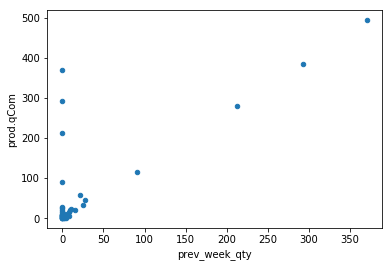

In [14]:
Xtr.plot.scatter(x='prev_week_qty', y='prod.qCom')

Now we train a Decision Tree model with our variables. With sklearn pipeline we can easily do the necessary transformations of the categoricals.

In [29]:
mdl = make_pipeline(OneHotEncoder(categorical_features=[0], handle_unknown='ignore'), 
                    DecisionTreeRegressor(min_samples_leaf=1, random_state=1))
mdl.fit(Xtr[['encoded_products','prev_week_qty']], Xtr['prod.qCom'])
p = mdl.predict(Xts[['encoded_products','prev_week_qty']])


print('Decision tree RMSLE:', np.sqrt(mean_squared_error(np.log1p(Xts['prod.qCom']),np.log1p(p))))

Decision tree RMSLE: 0.740095891472


We see the prediction is even worse than our simple baseline. As we thought, Machine Learning will not be able to help us with this amount of data. Let's try removing the problematic "last week sales" variable, as half of the training data doesn't have it.

In [30]:
mdl = make_pipeline(OneHotEncoder(categorical_features=[0], handle_unknown='ignore'), 
                    DecisionTreeRegressor(min_samples_leaf=1, random_state=1))
mdl.fit(Xtr[['encoded_products']], Xtr['prod.qCom'])
p = mdl.predict(Xts[['encoded_products']])

print('Decision tree RMSLE:', np.sqrt(mean_squared_error(np.log1p(Xts['prod.qCom']),np.log1p(p))))

Decision tree RMSLE: 0.414003052439


Although still bad from a practical perspective, we beat the baseline with our decision tree. Even though the sales last week is an important indicator, the fact we don't have good data about it makes it not useful for the model. With more data we can integrate many more variables to capture more effects, including seasonality.

Let's use all the data to train the model and predict week 4 with our "best" model

In [39]:
reverse_encoding = {v:k for k,v in encode_product.items()}
X = pd.concat([Xtr, Xts])
week4 = pd.DataFrame(X['encoded_products'].unique())
week4.columns = ['encoded_products']

In [40]:

mdl = make_pipeline(OneHotEncoder(categorical_features=[0], handle_unknown='ignore'), 
                    DecisionTreeRegressor(min_samples_leaf=1, random_state=1))
mdl.fit(X[['encoded_products']], X['prod.qCom'])
p = mdl.predict(week4)

In [45]:
week4_p = pd.DataFrame({'product': week4['encoded_products'].values, 'prediction': p})
week4_p['product'] = week4_p['product'].map(reverse_encoding)
week4_p[['product', 'prediction']]